<a href="https://colab.research.google.com/github/Vileno-C/image_reconstruction/blob/main/skimage_test_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from skimage import data, color
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve, correlate
import time
import pywt

In [65]:
print(dir(data))

['astronaut', 'binary_blobs', 'brain', 'brick', 'camera', 'cat', 'cell', 'cells3d', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'colorwheel', 'data_dir', 'download_all', 'eagle', 'file_hash', 'grass', 'gravel', 'horse', 'hubble_deep_field', 'human_mitosis', 'immunohistochemistry', 'kidney', 'lbp_frontal_face_cascade_filename', 'lfw_subset', 'lily', 'logo', 'microaneurysms', 'moon', 'nickel_solidification', 'page', 'palisades_of_vogt', 'protein_transport', 'retina', 'rocket', 'shepp_logan_phantom', 'skin', 'stereo_motorcycle', 'text', 'vortex']


(512, 512)


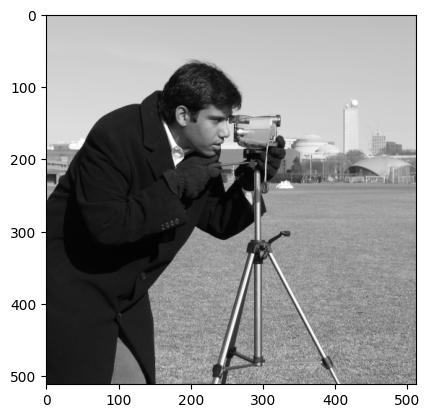

In [66]:
image = data.camera() # Carregar imagem
#image = color.rgb2gray(image) # Mudar p/ preto e branco
n = image.shape[0] # Tamanho da imagem

# n = max(image.shape)
# image = resize(image, (n, n), anti_aliasing=True) # Imagem quadrada

print(image .shape)
plt.imshow(image , cmap='grey')

In [67]:
n_kernel = 7 # Dimensão do kernel

# Imagem constante
kernel = np.full((n_kernel, n_kernel), 1/(n_kernel**2))

# Definir operadores
def A(x):
    return convolve(x, kernel, mode='same')

def AT(x):
    return correlate(x, kernel, mode='same')

In [68]:
# Verificar se A é adjunta de de AT

x = 10*np.random.rand(image.shape[0], image.shape[1])
y = 10*np.random.rand(image.shape[0], image.shape[1])

print(np.sum(A(x)*y))
print(np.sum(x*AT(y)))

6501062.183792898
6501062.183792898


In [69]:
# Wavelet escolhida
wav = 'db5'

def H(x):
    coeffs = pywt.wavedec2(x, wav, mode='periodization')
    arr, slices = pywt.coeffs_to_array(coeffs)
    return arr, slices

def HT(arr, slices):
    coeffs = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, wav, mode='periodization')


In [70]:
# Verificar se H é adjunta de HT

x = 10*np.random.rand(image.shape[0], image.shape[1])
y = 10*np.random.rand(image.shape[0], image.shape[1])

Hx = H(x)
print(np.sum(Hx[0]*y))
print(np.sum(x*HT(y, Hx[1])))

err = np.abs(image - HT(*H(image)))
print(np.sum(err))

213189.25585239398
213189.25585239392
1.810148117509236e-08


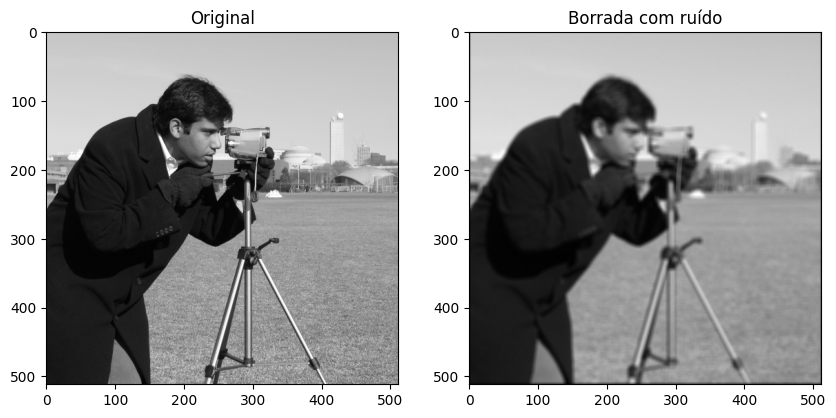

In [71]:
# Imagem borrada e ruida
episilon = 1
b_star = A(image) # Imagem borrada
b = b_star + episilon*np.random.randn(n, n) # Ruido gaussiano

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(b, cmap='gray')
plt.title('Borrada com ruído')

plt.show()

In [81]:
def f(x):
    return 0.5 * np.linalg.norm(A(x) - b)**2

def grad(x):
    return AT(A(x) - b)

def exact_step(x):
    g = grad(x)
    Ag = A(g)               # A * grad
    ATAg = AT(Ag)           # A^T * (A * grad)
    num = np.sum(g * g)     # numerador
    den = np.sum(g * ATAg)  # denominador
    return num / den

# Proximal
def prox(x, alpha):
    Hx = H(x)
    return HT(pywt.threshold(Hx[0], alpha), Hx[1])

# Método ISTA
def ista(x0=None, step=None, prox=None, gamma=None, max_iters=100, tol=None, x_star=None):
    x = np.zeros((n, n)) if x0 is None else x0 # chute inicial
    x_values = [x]
    time_per_iter = [0]

    for k in range(max_iters):

        t0 = time.time()
        if step is None:
            step = exact_step(x) # passo exato

        if prox is not None:
            x = prox(x -step * grad(x), step*gamma)

        x = x -step * grad(x)

        # Critério de parada
        if tol is not None and x_star is not None:
            if np.linalg.norm(x - x_star) / np.linalg.norm(x_star) <= tol:
                print(f"Gradiente parou na iteração {k}")
                x_values.append(x)
                break

        t1 = time.time()
        x_values.append(x)
        time_per_iter.append(t1 - t0)

    return x_values, time_per_iter

# Método de Nesterov
def fista(x0=None, step=None, prox=None, gamma=None, max_iters=100, tol=None, x_star=None):
    x = np.zeros((n, n)) if x0 is None else x0 # chute inicial
    x_values = [x]
    y_prev = np.copy(x)
    t_next = 1
    time_per_iter = [0]

    for k in range(max_iters):

        t0 = time.time()
        if step is None:
            step = exact_step(x) # passo exato

        if prox is not None:
            x = prox(x -step * grad(x), step*gamma)

        y = x - step * grad(x)
        t = t_next
        t_next = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        x = y + ((t - 1) / t_next) * (y - y_prev)

        # Critério de parada
        if tol is not None and x_star is not None:
            if np.linalg.norm(x - x_star) / np.linalg.norm(x_star) <= tol:
                print(f"Nestererov parou na iteração {k}")
                x_values.append(x)
                break

        y_prev = y
        t1 = time.time()

        time_per_iter.append(t1 - t0)
        x_values.append(x)

    return x_values, time_per_iter

# Método dos Gradientes Conjugados
def conjugate_grad(x0=None, max_iters=100, tol=None, x_star=None):
    x = np.zeros((n, n)) if x0 is None else x0 # chute inicial
    r = AT(b - A(x))
    p = np.copy(r)
    rsold = np.sum(r * r)
    x_values = [x]
    time_per_iter = [0]

    for k in range(max_iters):

        t0 = time.time()
        Ap = AT(A(p))
        alpha = rsold / np.sum(p * Ap)
        x = x + alpha * p

        # Critério de parada
        if tol is not None and x_star is not None:
            if np.linalg.norm(x - x_star) / np.linalg.norm(x_star) <= tol:
                print(f"Nestererov parou na iteração {k}")
                x_values.append(x)
                break

        r = r - alpha * Ap
        rsnew = np.sum(r * r)
        if np.sqrt(rsnew) < 1e-8:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

        t1 = time.time()
        x_values.append(x)
        time_per_iter.append(t1 - t0)

    return x_values, time_per_iter

In [83]:
#----------------------
# Executar métodos
#----------------------

# FISTA
gamma = 10e-2
Lambda = 0.5
x_values_f, time_iter_f = ista(prox=prox, gamma=gamma)
reconstruction_f = x_values_f[-1] # Imagem resconstruída
f_values_f = [f(x) + gamma*np.sum(np.abs(H(x)[0])) for x in x_values_f] # Valores de f a cada iteração

# Nesterov
x_values_n, time_ter_n = fista()
reconstruction_n = x_values_n[-1]
f_values_n = [f(x) + gamma*np.sum(np.abs(H(x)[0])) for x in x_values_n]

# Gradientes conjugados
x_values_cg, time_iter_cg = conjugate_grad()
reconstruction_cg = x_values_cg[-1]
f_values_cg = [f(x) + gamma*np.sum(np.abs(H(x)[0])) for x in x_values_cg]


# Análise do ganho de velocidade de convergência

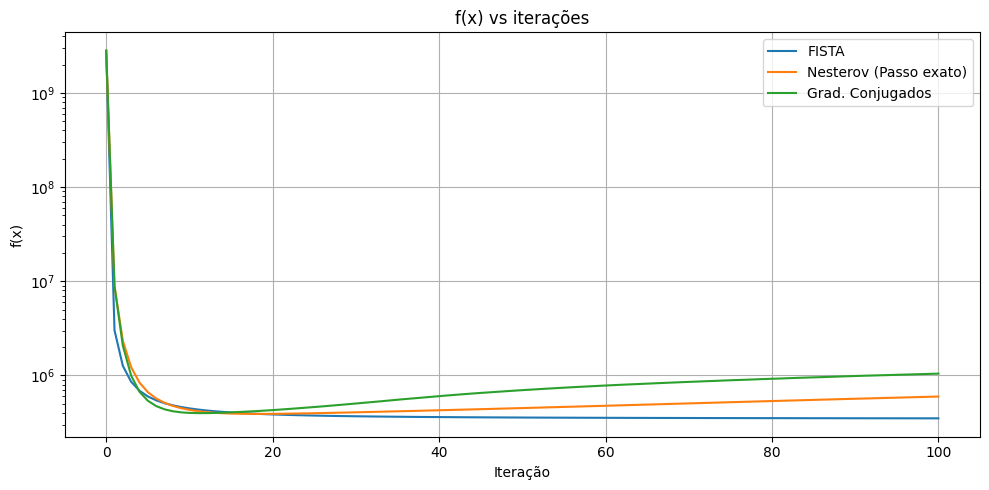

In [84]:
# ----------------------------
# Plot das funções f(x)
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(f_values_f, label="FISTA")
plt.plot(f_values_n, label="Nesterov (Passo exato)")
plt.plot(f_values_cg, label="Grad. Conjugados")
plt.title("f(x) vs iterações")
plt.yscale("log")
plt.xlabel("Iteração")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

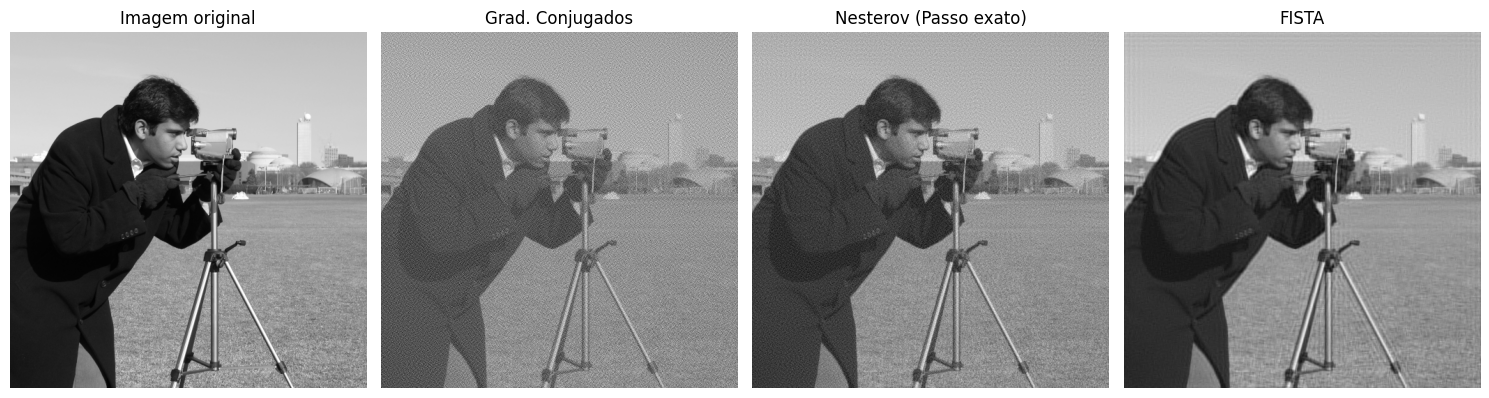

In [85]:
# ----------------------------
# Visualização
# ----------------------------
plt.figure(figsize=(15, 7))

# Imagem original
plt.subplot(1, 4, 1)
plt.title("Imagem original")
plt.imshow(image, cmap="gray")
plt.axis("off")

# Reconstrução - Gradientes Conjugados
plt.subplot(1, 4, 2)
plt.title("Grad. Conjugados")
plt.imshow(reconstruction_cg, cmap="gray")
plt.axis("off")

# Reconstrução - Gradiente passo exato
plt.subplot(1, 4, 3)
plt.title("Nesterov (Passo exato)")
plt.imshow(reconstruction_n, cmap="gray")
plt.axis("off")

# Reconstrução - Gradiente passo fixo
plt.subplot(1, 4, 4)
plt.title("FISTA")
plt.imshow(reconstruction_f, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()